In [1]:
import pandas as pd
product = pd.read_csv('pricerunner_aggregate.csv')
print(product.head())

   Product ID                                      Product Title  \
0           1                    apple iphone 8 plus 64gb silver   
1           2                apple iphone 8 plus 64 gb spacegrau   
2           3  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...   
3           4                apple iphone 8 plus 64gb space grey   
4           5  apple iphone 8 plus gold 5.5 64gb 4g unlocked ...   

    Merchant ID   Cluster ID             Cluster Label   Category ID  \
0             1            1  Apple iPhone 8 Plus 64GB          2612   
1             2            1  Apple iPhone 8 Plus 64GB          2612   
2             3            1  Apple iPhone 8 Plus 64GB          2612   
3             4            1  Apple iPhone 8 Plus 64GB          2612   
4             5            1  Apple iPhone 8 Plus 64GB          2612   

   Category Label  
0   Mobile Phones  
1   Mobile Phones  
2   Mobile Phones  
3   Mobile Phones  
4   Mobile Phones  


# DBSCAN Clustering Analysis

This notebook applies DBSCAN clustering to two datasets:
1. **Product Dataset**: Using cosine distance on TF-IDF encoded product titles
2. **Twitter Dataset**: Using L2 (Euclidean) distance on scaled location/timestamp features

## Product Dataset - Feature Engineering

Encode product titles using TF-IDF vectorization

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
# TF-IDF handles tokenization automatically and gives more weight to rare, informative words
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,  # Limit to top 500 features to manage dimensionality
    min_df=2,          # Ignore terms that appear in fewer than 2 documents
    max_df=0.8         # Ignore terms that appear in more than 80% of documents
)

# Fit and transform the product titles directly (no manual tokenization needed!)
product_title_encoded = tfidf_vectorizer.fit_transform(product['Product Title'])

print(f"Encoding Statistics:")
print(f"Original titles: {len(product)}")
print(f"Encoded shape: {product_title_encoded.shape}")
print(f"  - {product_title_encoded.shape[0]} documents")
print(f"  - {product_title_encoded.shape[1]} features (unique tokens)")
print(f"\nVocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Sparsity: {(1.0 - product_title_encoded.nnz / (product_title_encoded.shape[0] * product_title_encoded.shape[1])) * 100:.2f}%")

# Show sample feature names
print(f"\nSample features (tokens): {list(tfidf_vectorizer.get_feature_names_out())[:20]}")

Encoding Statistics:
Original titles: 35311
Encoded shape: (35311, 500)
  - 35311 documents
  - 500 features (unique tokens)

Vocabulary size: 500
Sparsity: 98.78%

Sample features (tokens): ['10', '1000', '1080p', '10kg', '1151', '12', '1200', '1200rpm', '128gb', '12mb', '13', '13ghz', '14', '1400', '1400rpm', '15', '1500', '16', '1600', '1600rpm']


## Product Dataset - DBSCAN with Cosine Distance

## Epsilon Parameter Tuning - K-Distance Plot

The k-distance plot helps us choose an appropriate epsilon value for DBSCAN:
1. For each point, compute the distance to its k-th nearest neighbor
2. Sort these distances in ascending order
3. Plot them to find the "elbow point" where the curve has the sharpest increase
4. The distance at the elbow is a good candidate for epsilon

In [3]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Choose k = min_samples (the minimum number of neighbors for a core point)
# This is typically set to the same value you'll use for min_samples in DBSCAN
k = 5  # Using 5 as you have min_samples=5 in your DBSCAN

# Fit NearestNeighbors to find k-nearest neighbors for each point
# Use the same metric (cosine) as DBSCAN
neighbors = NearestNeighbors(n_neighbors=k, metric='cosine')
neighbors.fit(product_title_encoded)

# Get distances to k-th nearest neighbor for each point
distances, indices = neighbors.kneighbors(product_title_encoded)

# Sort the distances in ascending order
# We take the last column (k-th neighbor, index -1)
k_distances = np.sort(distances[:, -1])

print(f"Computing {k}-distance plot for {len(k_distances)} samples...")
print(f"Distance range: [{k_distances.min():.4f}, {k_distances.max():.4f}]")
print(f"Median distance: {np.median(k_distances):.4f}")
print(f"75th percentile: {np.percentile(k_distances, 75):.4f}")
print(f"90th percentile: {np.percentile(k_distances, 90):.4f}")
print(f"95th percentile: {np.percentile(k_distances, 95):.4f}")

Computing 5-distance plot for 35311 samples...
Distance range: [0.0000, 1.0000]
Median distance: 0.1320
75th percentile: 0.2181
90th percentile: 0.2991
95th percentile: 0.3543


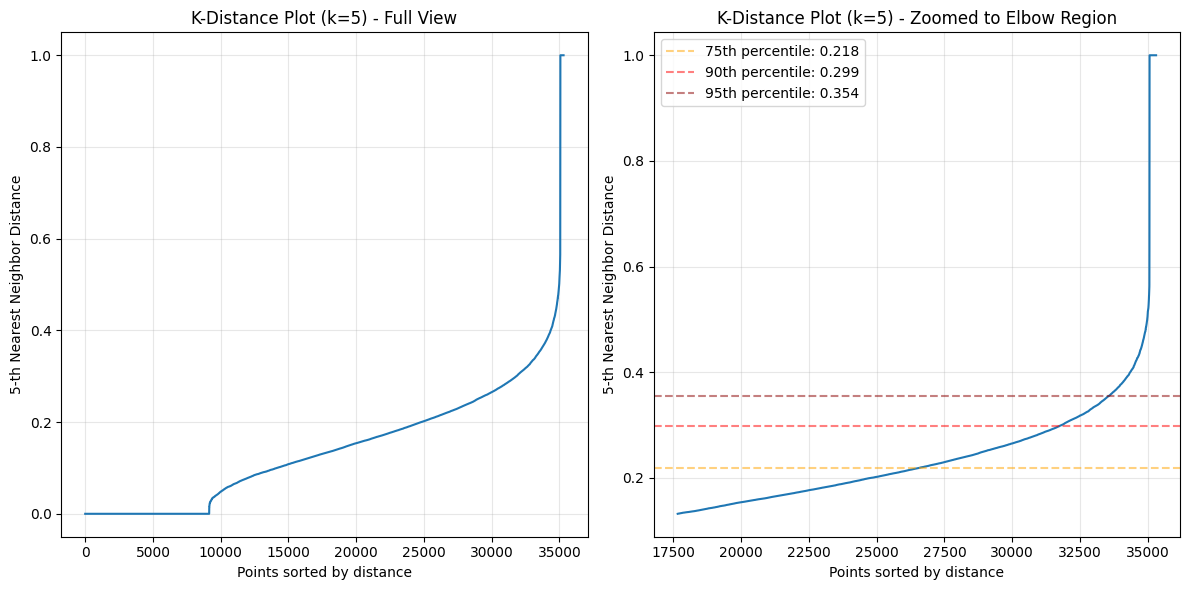


🎯 How to choose epsilon:
   1. Look for the 'elbow' point where the curve sharply increases
   2. The y-value at that point is a good epsilon candidate
   3. Points to the left of the elbow will be in clusters
   4. Points to the right will likely be noise

💡 Current epsilon in your DBSCAN: 0.3
   Based on the plot, you might want to try values around the elbow point


In [4]:
# Plot the k-distance graph
plt.figure(figsize=(12, 6))

# Full plot
plt.subplot(1, 2, 1)
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title(f'K-Distance Plot (k={k}) - Full View')
plt.grid(True, alpha=0.3)

# Zoomed plot focusing on the elbow region
plt.subplot(1, 2, 2)
# Focus on the right side where the elbow typically appears
focus_start = int(len(k_distances) * 0.5)  # Start from 50% of points
plt.plot(range(focus_start, len(k_distances)), k_distances[focus_start:])
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title(f'K-Distance Plot (k={k}) - Zoomed to Elbow Region')
plt.grid(True, alpha=0.3)

# Add reference lines for common percentiles
for percentile, color in [(75, 'orange'), (90, 'red'), (95, 'darkred')]:
    value = np.percentile(k_distances, percentile)
    plt.axhline(y=value, color=color, linestyle='--', alpha=0.5, 
                label=f'{percentile}th percentile: {value:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print("\n🎯 How to choose epsilon:")
print("   1. Look for the 'elbow' point where the curve sharply increases")
print("   2. The y-value at that point is a good epsilon candidate")
print("   3. Points to the left of the elbow will be in clusters")
print("   4. Points to the right will likely be noise")
print(f"\n💡 Current epsilon in your DBSCAN: 0.3")
print(f"   Based on the plot, you might want to try values around the elbow point")

### Test Different Epsilon Values

Now let's test several epsilon values around the elbow point to see how they affect clustering quality:

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Test multiple epsilon values - using smaller values appropriate for cosine distance
# Cosine distance ranges from 0 (identical) to 2 (opposite), so typical values are < 0.5
epsilon_values = [0.05, 0.08, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.30]
min_samples = 5  # Keep this constant

results = []

print("Testing different epsilon values...\n")
print("=" * 100)

for eps in epsilon_values:
    # Run DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    clusters = dbscan.fit_predict(product_title_encoded)
    
    # Calculate metrics
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)
    noise_pct = (n_noise / len(clusters)) * 100
    
    # External metrics (comparing to ground truth)
    ari = adjusted_rand_score(product[' Cluster ID'], clusters)
    nmi = normalized_mutual_info_score(product[' Cluster ID'], clusters)
    
    # Silhouette score (internal metric, only if we have clusters)
    # Note: silhouette_score doesn't work well with -1 (noise) labels
    non_noise_mask = clusters != -1
    if n_clusters > 1 and non_noise_mask.sum() > 1:
        try:
            # Calculate silhouette only on non-noise points
            silhouette = silhouette_score(
                product_title_encoded[non_noise_mask], 
                clusters[non_noise_mask], 
                metric='cosine'
            )
        except:
            silhouette = None
    else:
        silhouette = None
    
    results.append({
        'epsilon': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct,
        'ARI': ari,
        'NMI': nmi,
        'silhouette': silhouette
    })
    
    print(f"eps={eps:.2f} | Clusters: {n_clusters:3d} | Noise: {n_noise:4d} ({noise_pct:5.1f}%) | "
          f"ARI: {ari:6.4f} | NMI: {nmi:6.4f} | Silhouette: {silhouette if silhouette else 'N/A':>6}")

print("=" * 100)

Testing different epsilon values...

eps=0.10 | Clusters: 1244 | Noise: 19569 ( 55.4%) | ARI: 0.0001 | NMI: 0.4747 | Silhouette: 0.7308145694637167
eps=0.10 | Clusters: 1244 | Noise: 19569 ( 55.4%) | ARI: 0.0001 | NMI: 0.4747 | Silhouette: 0.7308145694637167
eps=0.15 | Clusters: 1027 | Noise: 12845 ( 36.4%) | ARI: 0.0003 | NMI: 0.5416 | Silhouette: 0.332942935932254
eps=0.15 | Clusters: 1027 | Noise: 12845 ( 36.4%) | ARI: 0.0003 | NMI: 0.5416 | Silhouette: 0.332942935932254
eps=0.20 | Clusters: 465 | Noise: 7257 ( 20.6%) | ARI: 0.0005 | NMI: 0.4210 | Silhouette: -0.10444673106064081
eps=0.20 | Clusters: 465 | Noise: 7257 ( 20.6%) | ARI: 0.0005 | NMI: 0.4210 | Silhouette: -0.10444673106064081
eps=0.25 | Clusters: 161 | Noise: 3612 ( 10.2%) | ARI: 0.0001 | NMI: 0.1894 | Silhouette: -0.26112767608650456
eps=0.25 | Clusters: 161 | Noise: 3612 ( 10.2%) | ARI: 0.0001 | NMI: 0.1894 | Silhouette: -0.26112767608650456
eps=0.30 | Clusters:  46 | Noise: 1746 (  4.9%) | ARI: 0.0000 | NMI: 0.0535 |

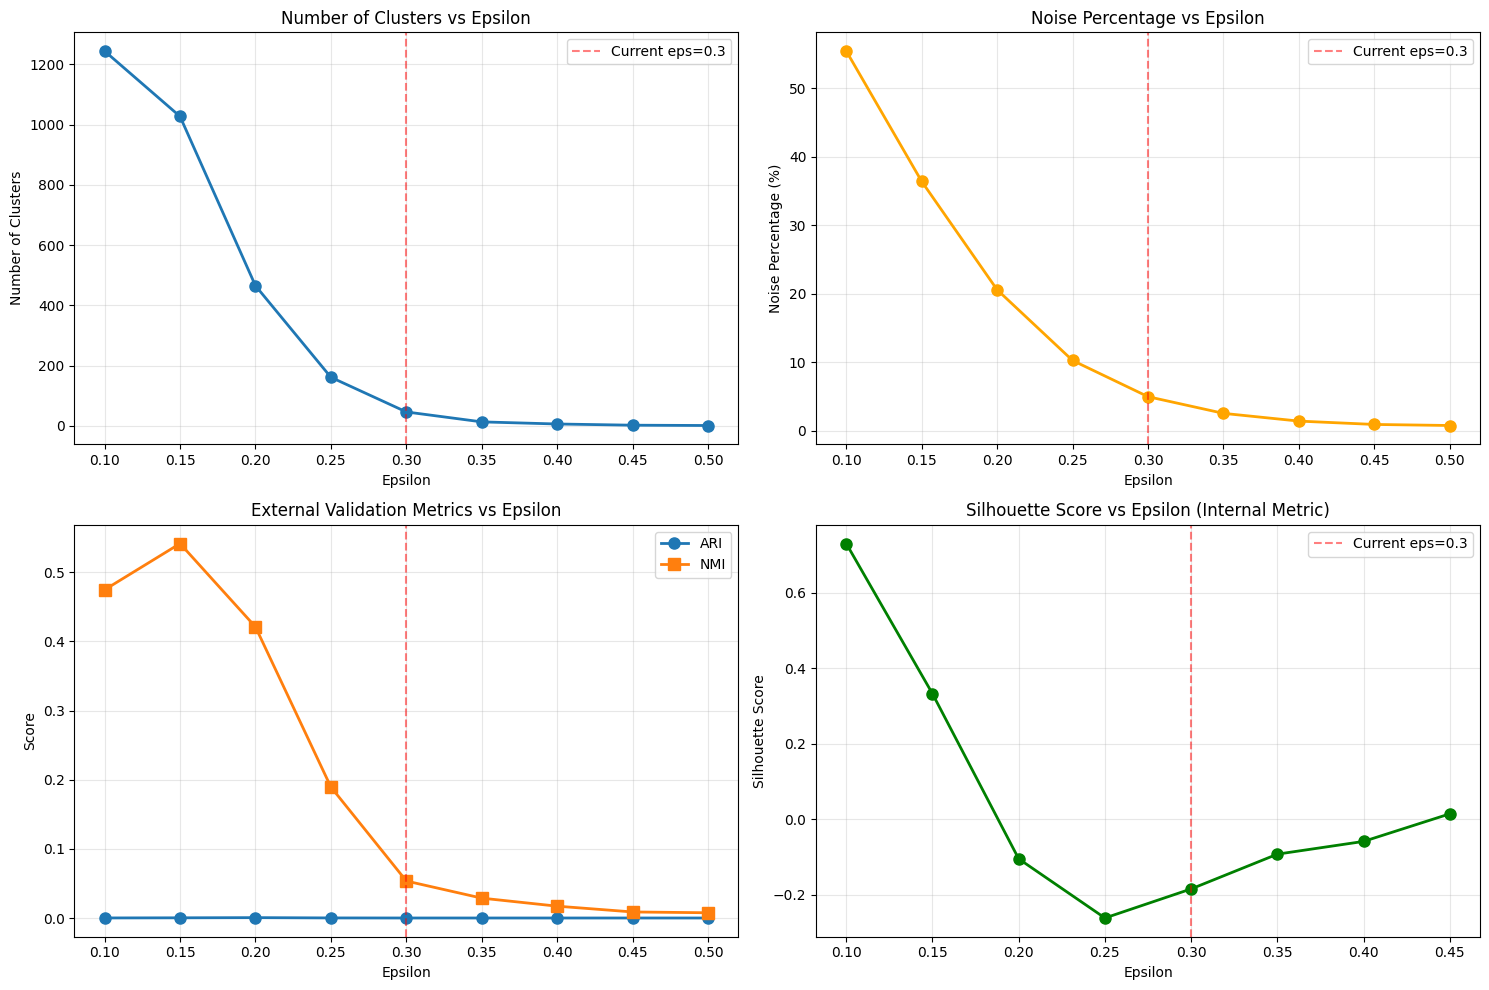


🏆 Best epsilon based on ARI: 0.2
   ARI: 0.0005
   Clusters: 465
   Noise: 20.6%


In [6]:
# Visualize the results
results_df = pd.DataFrame(results)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Number of clusters vs epsilon
ax1 = axes[0, 0]
ax1.plot(results_df['epsilon'], results_df['n_clusters'], 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Epsilon')
ax1.set_ylabel('Number of Clusters')
ax1.set_title('Number of Clusters vs Epsilon')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=0.3, color='red', linestyle='--', alpha=0.5, label='Current eps=0.3')
ax1.legend()

# Plot 2: Noise percentage vs epsilon
ax2 = axes[0, 1]
ax2.plot(results_df['epsilon'], results_df['noise_pct'], 'o-', color='orange', linewidth=2, markersize=8)
ax2.set_xlabel('Epsilon')
ax2.set_ylabel('Noise Percentage (%)')
ax2.set_title('Noise Percentage vs Epsilon')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0.3, color='red', linestyle='--', alpha=0.5, label='Current eps=0.3')
ax2.legend()

# Plot 3: ARI and NMI vs epsilon
ax3 = axes[1, 0]
ax3.plot(results_df['epsilon'], results_df['ARI'], 'o-', label='ARI', linewidth=2, markersize=8)
ax3.plot(results_df['epsilon'], results_df['NMI'], 's-', label='NMI', linewidth=2, markersize=8)
ax3.set_xlabel('Epsilon')
ax3.set_ylabel('Score')
ax3.set_title('External Validation Metrics vs Epsilon')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.axvline(x=0.3, color='red', linestyle='--', alpha=0.5, label='Current eps=0.3')

# Plot 4: Silhouette score vs epsilon
ax4 = axes[1, 1]
silhouette_valid = results_df[results_df['silhouette'].notna()]
ax4.plot(silhouette_valid['epsilon'], silhouette_valid['silhouette'], 'o-', 
         color='green', linewidth=2, markersize=8)
ax4.set_xlabel('Epsilon')
ax4.set_ylabel('Silhouette Score')
ax4.set_title('Silhouette Score vs Epsilon (Internal Metric)')
ax4.grid(True, alpha=0.3)
ax4.axvline(x=0.3, color='red', linestyle='--', alpha=0.5, label='Current eps=0.3')
ax4.legend()

plt.tight_layout()
plt.show()

# Find the best epsilon based on ARI
best_ari_idx = results_df['ARI'].idxmax()
best_eps = results_df.loc[best_ari_idx, 'epsilon']
print(f"\n🏆 Best epsilon based on ARI: {best_eps}")
print(f"   ARI: {results_df.loc[best_ari_idx, 'ARI']:.4f}")
print(f"   Clusters: {results_df.loc[best_ari_idx, 'n_clusters']}")
print(f"   Noise: {results_df.loc[best_ari_idx, 'noise_pct']:.1f}%")

In [7]:
from sklearn.cluster import DBSCAN
import numpy as np

# Apply DBSCAN clustering on the full product dataset
# Using cosine distance on TF-IDF encoded titles
product_dbscan = DBSCAN(
    eps=0.3,           # Maximum distance between samples (tune this parameter)
    min_samples=5,     # Minimum samples in a neighborhood (tune this parameter)
    metric='cosine'    # Use cosine distance
)

# Fit and predict clusters on all product data
product_clusters = product_dbscan.fit_predict(product_title_encoded)

# Add cluster assignments to the dataframe
product['dbscan_cluster'] = product_clusters

# Display results
print("Product DBSCAN Results (Cosine Distance):")
print(f"  Total samples: {len(product_clusters)}")
print(f"  Clusters found: {len(set(product_clusters)) - (1 if -1 in product_clusters else 0)}")
print(f"  Noise points: {list(product_clusters).count(-1)} ({list(product_clusters).count(-1)/len(product_clusters)*100:.2f}%)")
print(f"\n  Cluster distribution (top 10 largest clusters):")
unique, counts = np.unique(product_clusters, return_counts=True)
sorted_indices = np.argsort(counts)[::-1][:10]
for idx in sorted_indices:
    cluster, count = unique[idx], counts[idx]
    if cluster == -1:
        print(f"    Noise (-1): {count} samples")
    else:
        print(f"    Cluster {cluster}: {count} samples")

Product DBSCAN Results (Cosine Distance):
  Total samples: 35311
  Clusters found: 46
  Noise points: 1746 (4.94%)

  Cluster distribution (top 10 largest clusters):
    Cluster 0: 32920 samples
    Noise (-1): 1746 samples
    Cluster 37: 110 samples
    Cluster 9: 99 samples
    Cluster 17: 46 samples
    Cluster 7: 40 samples
    Cluster 33: 39 samples
    Cluster 44: 33 samples
    Cluster 13: 17 samples
    Cluster 24: 17 samples


## Product Dataset - Compare with Ground Truth Labels

In [8]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure

# Compare DBSCAN clusters with actual Cluster ID labels
actual_labels = product[' Cluster ID']

# Calculate clustering evaluation metrics
ari = adjusted_rand_score(actual_labels, product_clusters)
nmi = normalized_mutual_info_score(actual_labels, product_clusters)
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(actual_labels, product_clusters)

print("Product Dataset - Clustering Evaluation:")
print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
print(f"    (1.0 = perfect match, 0.0 = random, negative = worse than random)")
print(f"\n  Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"    (1.0 = perfect match, 0.0 = no mutual information)")
print(f"\n  Homogeneity: {homogeneity:.4f}")
print(f"    (1.0 = each cluster contains only members of a single class)")
print(f"  Completeness: {completeness:.4f}")
print(f"    (1.0 = all members of a given class are in the same cluster)")
print(f"  V-Measure: {v_measure:.4f}")
print(f"    (harmonic mean of homogeneity and completeness)")

# Show some example mappings
print(f"\n  Sample cluster assignments vs actual labels:")
sample_df = product[[' Cluster Label', 'dbscan_cluster']].head(20)
print(sample_df.to_string())

Product Dataset - Clustering Evaluation:
  Adjusted Rand Index (ARI): 0.0000
    (1.0 = perfect match, 0.0 = random, negative = worse than random)

  Normalized Mutual Information (NMI): 0.0535
    (1.0 = perfect match, 0.0 = no mutual information)

  Homogeneity: 0.0277
    (1.0 = each cluster contains only members of a single class)
  Completeness: 0.7385
    (1.0 = all members of a given class are in the same cluster)
  V-Measure: 0.0535
    (harmonic mean of homogeneity and completeness)

  Sample cluster assignments vs actual labels:
               Cluster Label  dbscan_cluster
0   Apple iPhone 8 Plus 64GB               0
1   Apple iPhone 8 Plus 64GB               0
2   Apple iPhone 8 Plus 64GB               0
3   Apple iPhone 8 Plus 64GB               0
4   Apple iPhone 8 Plus 64GB               0
5   Apple iPhone 8 Plus 64GB               0
6   Apple iPhone 8 Plus 64GB               0
7   Apple iPhone 8 Plus 64GB               0
8   Apple iPhone 8 Plus 64GB               0
9   A

## Product Dataset - Cluster Mapping Analysis

Analyze how DBSCAN clusters map to ground truth labels (cluster labels are arbitrary, so we need to see the overlap)

In [9]:
import pandas as pd

# Create a confusion matrix-like view: DBSCAN clusters vs Ground Truth labels
# This shows which ground truth labels appear in each DBSCAN cluster

print("Cluster Mapping: DBSCAN Cluster → Ground Truth Labels")
print("=" * 80)

# Get unique DBSCAN clusters (excluding noise if desired for clarity)
unique_dbscan_clusters = sorted([c for c in product['dbscan_cluster'].unique() if c != -1])

for dbscan_cluster in unique_dbscan_clusters[:10]:  # Show first 10 clusters
    # Get all products in this DBSCAN cluster
    cluster_data = product[product['dbscan_cluster'] == dbscan_cluster]
    
    # Count ground truth labels in this cluster
    label_counts = cluster_data[' Cluster Label'].value_counts()
    total_in_cluster = len(cluster_data)
    
    print(f"\nDBSCAN Cluster {dbscan_cluster} ({total_in_cluster} products):")
    print(f"  Top ground truth labels:")
    for i, (label, count) in enumerate(label_counts.head(5).items(), 1):
        percentage = (count / total_in_cluster) * 100
        print(f"    {i}. '{label}': {count} ({percentage:.1f}%)")
    
    # Purity: percentage of most common label
    if len(label_counts) > 0:
        purity = (label_counts.iloc[0] / total_in_cluster) * 100
        print(f"  Purity: {purity:.1f}% (dominated by '{label_counts.index[0]}')")

# Overall cluster purity metric
def calculate_purity(true_labels, predicted_labels):
    """Calculate purity: fraction of samples in their majority class"""
    contingency_matrix = pd.crosstab(predicted_labels, true_labels)
    return contingency_matrix.max(axis=1).sum() / len(true_labels)

purity = calculate_purity(actual_labels, product_clusters)
print(f"\n{'=' * 80}")
print(f"Overall Cluster Purity: {purity:.4f}")
print(f"  (Higher is better, 1.0 means each cluster is pure)")

# Show noise cluster statistics
noise_count = (product_clusters == -1).sum()
if noise_count > 0:
    print(f"\nNoise Points (Cluster -1): {noise_count} products")
    noise_labels = product[product['dbscan_cluster'] == -1][' Cluster Label'].value_counts()
    print(f"  Top labels in noise:")
    for label, count in noise_labels.head(5).items():
        print(f"    '{label}': {count}")

Cluster Mapping: DBSCAN Cluster → Ground Truth Labels

DBSCAN Cluster 0 (32920 products):
  Top ground truth labels:
    1. 'Samsung UE49NU7100': 24 (0.1%)
    2. 'Samsung UE65NU7100': 23 (0.1%)
    3. 'Samsung UE75NU7100': 23 (0.1%)
    4. 'Canon IXUS 185': 23 (0.1%)
    5. 'Apple iPhone 7 Plus 32GB': 22 (0.1%)
  Purity: 0.1% (dominated by 'Samsung UE49NU7100')

DBSCAN Cluster 1 (9 products):
  Top ground truth labels:
    1. 'Apple iPhone 8 Plus 64GB': 1 (11.1%)
    2. 'Apple iPhone 8 64GB': 1 (11.1%)
    3. 'Apple iPhone X 64GB': 1 (11.1%)
    4. 'Apple iPhone X 256GB': 1 (11.1%)
    5. 'Apple iPhone 8 Plus 256GB': 1 (11.1%)
  Purity: 11.1% (dominated by 'Apple iPhone 8 Plus 64GB')

DBSCAN Cluster 2 (6 products):
  Top ground truth labels:
    1. 'Huawei Honor 10 128GB Dual SIM': 2 (33.3%)
    2. 'Huawei Honor View 10 128GB Dual SIM': 2 (33.3%)
    3. 'Huawei Honor 9 Lite 32GB Dual SIM': 1 (16.7%)
    4. 'Huawei Honor 7A 16GB Dual SIM': 1 (16.7%)
  Purity: 33.3% (dominated by 'Huawe